In [35]:
import gym
import numpy as np
import pyglet
import time
import torch
from torch import nn
import matplotlib.pyplot as plt

In [36]:
env = gym.make('Asterix-ram-v0')
gamma = 1
n_episodes = 200
max_step = 10000
eps = 0.001
gamma_pwr = gamma ** np.arange(max_step)

In [37]:
device = 'cuda:0'
net = nn.Sequential(
                    #nn.Linear(128, 128),
                    #nn.LeakyReLU(0.01),
                    nn.Linear(128, 64),
                    nn.LeakyReLU(0.01),
                    nn.Linear(64, 9),
                    nn.Softmax()
                    )
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.95)

In [38]:
total_rewards = []
freq = max(n_episodes // 20, 1)

In [40]:
for episode in range(n_episodes):
    state = torch.tensor(env.reset(), dtype=torch.float32).to(device)
    logs = []
    rewards = []
    for step in range(max_step):
        policy = net(state)
        #if step % 1000 == 0:
        #    print('max policy:', max(policy))
        q = np.random.choice(np.arange(2), p=[eps, 1 - eps])
        if q:
            action = np.random.choice(np.arange(9), p=policy.cpu().detach().numpy())
        else:
            action = np.random.randint(9)
        log = torch.log(policy[action] + 1e-6)
        #print(log)
        logs.append(log)
        state, reward, done, info = env.step(action)
        state = torch.tensor(state, dtype=torch.float32).to(device)
        
        rewards.append(reward)
        if done:
            break
    T = len(rewards)
    #print(rewards[-1])
    rewards = np.array(rewards)
    total_rewards.append(rewards.sum())
    G = []
    for t in range(T):
        g = (gamma_pwr[t:T] * rewards[t:]).sum()
        G.append(g)
    grads = 0
    for log, g in zip(logs, G):
        grads -= g * log
    
    optimizer.zero_grad()
    grads.to(device).backward()
    optimizer.step()
    scheduler.step()
    if not episode % freq:
        print('Episode: {}/{} || Reward: {}  Steps: {}'.format(episode, n_episodes, total_rewards[-1], T))
        print('grad:', grads)

Episode: 0/200 || Reward: 600.0  Steps: 1813
grad: tensor(68985.8047, device='cuda:0', grad_fn=<SubBackward0>)
Episode: 10/200 || Reward: 200.0  Steps: 753
grad: tensor(-0.0533, device='cuda:0', grad_fn=<SubBackward0>)
Episode: 20/200 || Reward: 200.0  Steps: 751
grad: tensor(-0.0536, device='cuda:0', grad_fn=<SubBackward0>)
Episode: 30/200 || Reward: 200.0  Steps: 765
grad: tensor(1381.5037, device='cuda:0', grad_fn=<SubBackward0>)
Episode: 40/200 || Reward: 200.0  Steps: 760
grad: tensor(-0.0535, device='cuda:0', grad_fn=<SubBackward0>)
Episode: 50/200 || Reward: 200.0  Steps: 771
grad: tensor(-0.0540, device='cuda:0', grad_fn=<SubBackward0>)
Episode: 60/200 || Reward: 150.0  Steps: 573
grad: tensor(690.7488, device='cuda:0', grad_fn=<SubBackward0>)
Episode: 70/200 || Reward: 200.0  Steps: 783
grad: tensor(-0.0552, device='cuda:0', grad_fn=<SubBackward0>)
Episode: 80/200 || Reward: 200.0  Steps: 708
grad: tensor(1381.5096, device='cuda:0', grad_fn=<SubBackward0>)
Episode: 90/200 || R

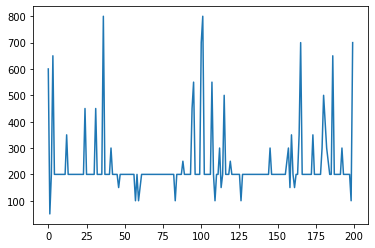

In [41]:
plt.plot(total_rewards);

In [42]:
np.mean(total_rewards)

233.75

In [43]:
next(net.parameters())

Parameter containing:
tensor([[ 0.0047,  0.0158,  0.0335,  ...,  0.0541,  0.0292, -0.0550],
        [ 0.0779,  0.0777,  0.0394,  ..., -0.0008,  0.0239, -0.0474],
        [-0.0054,  0.0203, -0.0349,  ..., -0.0091, -0.0544, -0.0811],
        ...,
        [-0.0703,  0.0823, -0.0357,  ...,  0.0327, -0.0178, -0.0854],
        [-0.0280,  0.0341,  0.0460,  ...,  0.0220, -0.0559, -0.0292],
        [ 0.0234,  0.0067,  0.0537,  ..., -0.0366, -0.1019, -0.0085]],
       device='cuda:0', requires_grad=True)